Originally from isolate_with_bedell.ipynb in the sculpting repo, I've adapted this former subsection of Lam & Ballard 2024 (submitted) into its own paper.

In [20]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm
%matplotlib inline
path = '/Users/chris/Desktop/mastrangelo/'
# all data downloaded from Berger et al 2020's ancillary tables: https://arxiv.org/src/2001.07737v3/anc
# the paper we're comparing against: https://arxiv.org/pdf/2005.14671.pdf


In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [12]:
# read in Berger crossmatch
kepler_stellar_enriched = pd.read_csv(path+'data/berger_kepler_stellar_fgk.csv')
kepler_planet_enriched = pd.read_csv(path+'data/pnum_plus_cands_fgk.csv')


/Users/chris/anaconda2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Compute k

In [13]:
print(kepler_planet_enriched.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())

           kepid
koi_count       
1            833
2            134
3             38
4             15
5              5


Test: divide into "young" and "old" k's

In [15]:
young_all = kepler_stellar_enriched.loc[kepler_stellar_enriched.iso_age <= 2.]
old_all = kepler_stellar_enriched.loc[kepler_stellar_enriched.iso_age > 2.]

young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age <= 2.]
old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age > 2.]
print(young.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())

print(old.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())


           kepid
koi_count       
1             99
2             20
3              5
4              2
           kepid
koi_count       
1            734
2            114
3             33
4             13
5              5


### Period ratios

In [16]:
kepler_planet_enriched.koi_period

0       27.556452
1        9.931463
2        4.578344
3        7.407425
4       40.806533
          ...    
1295     6.830062
1296    49.490598
1297    37.793511
1298    24.668383
1299     1.847893
Name: koi_period, Length: 1300, dtype: float64

In [17]:
kepler_planet_enriched.iso_age

0       13.04
1        6.26
2        6.26
3        4.02
4        2.38
        ...  
1295     6.44
1296     1.78
1297     3.11
1298     2.26
1299     7.02
Name: iso_age, Length: 1300, dtype: float64

In [18]:
kepler_planet_enriched.kepid

0        1293379
1        1432789
2        1432789
3        1725016
4        1871056
          ...   
1295    12645057
1296    12690465
1297    12735793
1298    12737015
1299    12784167
Name: kepid, Length: 1300, dtype: int64

In [21]:
def quotient(a, b):
    return max(a,b)/min(a,b)

threshold = 4
### koi_score
young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age <= threshold]
old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age > threshold]

### fpp_prob
#young = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.iso_age <= threshold]
#old = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.iso_age > threshold]

old_ratios = []
young_ratios = []
all_ratios = []
for i in np.unique(old.kepid):
    system = old.loc[old.kepid == i]
    
    if len(system) > 1: # if multi
        
        pairs = itertools.combinations(system.koi_period, r=2)
        
        for pair in pairs:
            #print(quotient(*pair))
            old_ratios.append(quotient(*pair))
            
        #ratios = []
        """
        for sma in subset.koi_sma:
            all_ratios.append(ratio)
        """
        
for i in np.unique(young.kepid):
    system = young.loc[young.kepid == i]
    
    if len(system) > 1: # if multi
        
        pairs = itertools.combinations(system.koi_period, r=2)
        
        for pair in pairs:
            young_ratios.append(quotient(*pair))

for i in np.unique(kepler_planet_enriched.kepid):
    system = kepler_planet_enriched.loc[kepler_planet_enriched.kepid == i]
    
    if len(system) > 1: # if multi
        
        pairs = itertools.combinations(system.koi_period, r=2)
        
        for pair in pairs:
            all_ratios.append(quotient(*pair))
            
old_ratios = np.array(old_ratios)      
young_ratios = np.array(young_ratios)      
all_ratios = np.array(all_ratios)

print("K-S test result from comparing young and old: ", kstest(young_ratios, old_ratios))


K-S test result from comparing young and old:  KstestResult(statistic=0.06913165266106443, pvalue=0.7372817130685656)


old:  175
young:  117


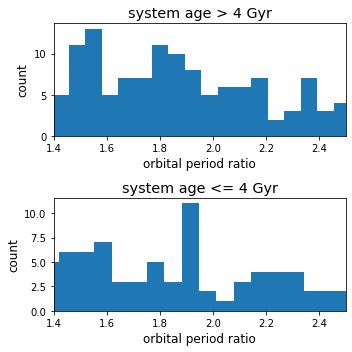

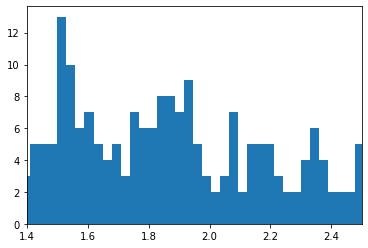

K-S test result from comparing young and old:  KstestResult(statistic=0.12727716727716729, pvalue=0.18343781123368175)


In [22]:
fig, axes = plt.subplots(figsize=(5,5))

cut = 4
bins = 45
ax1 = plt.subplot2grid((2,1), (0,0))
old_ratios = old_ratios[old_ratios < cut]
print("old: ", len(old_ratios))
ax1.hist(old_ratios, bins=bins)
ax1.set_title(f'system age > {threshold} Gyr')
ax1.set_xlabel('orbital period ratio')
ax1.set_ylabel('count')
ax1.set_xlim([0, cut])
ax1.set_xlim([1.4, 2.5])


ax2 = plt.subplot2grid((2,1), (1,0))
young_ratios = young_ratios[young_ratios < cut]
print("young: ", len(young_ratios))
ax2.hist(young_ratios, bins=bins)
ax2.set_title(f'system age <= {threshold} Gyr')
ax2.set_xlabel('orbital period ratio')
ax2.set_ylabel('count')
ax2.set_xlim([0, cut])
ax2.set_xlim([1.4, 2.5])


plt.tight_layout()
#plt.savefig(f'/Users/chrislam/Desktop/sculpting/paper/young-old-period-ratios-{threshold}gyr-fpp.png', format='png')
plt.show()

all_ratios = all_ratios[all_ratios < cut]
plt.hist(all_ratios, bins=100)
plt.xlim([1.4, 2.5])
plt.show()

print("K-S test result from comparing young and old: ", kstest(young_ratios, old_ratios))

In [23]:
print(len(old_ratios[(old_ratios > 1.9) & (old_ratios < 1.95)]))
print(len(old_ratios[(old_ratios > 1.95) & (old_ratios < 2.)]))
print(len(old_ratios[(old_ratios > 2) & (old_ratios < 2.05)]))
print(len(old_ratios[(old_ratios > 2.05) & (old_ratios < 2.1)]))
print(len(old_ratios[(old_ratios > 2.1) & (old_ratios < 2.15)]))
print(len(old_ratios[(old_ratios > 2.15) & (old_ratios < 2.2)]))
print("")

print(len(old_ratios[(old_ratios > 1.4) & (old_ratios < 1.5)]))
print(len(old_ratios[(old_ratios > 1.5) & (old_ratios < 1.6)]))

6
4
6
4
7
5

9
20


In [24]:
print(len(young_ratios[(young_ratios > 1.95) & (young_ratios < 2)]))
print(len(young_ratios[(young_ratios > 2) & (young_ratios < 2.05)]))
print(len(young_ratios[(young_ratios > 2.05) & (young_ratios < 2.1)]))
print("")

print(len(young_ratios[(young_ratios > 1.4) & (young_ratios < 1.5)]))
print(len(young_ratios[(young_ratios > 1.5) & (young_ratios < 1.6)]))

1
1
3

6
12


In [25]:
print(len(all_ratios[(all_ratios > 1.9) & (all_ratios < 2)]))
print(len(all_ratios[(all_ratios > 2) & (all_ratios < 2.1)]))
print(len(all_ratios[(all_ratios > 2.1) & (all_ratios < 2.2)]))
print(len(all_ratios[(all_ratios > 2.2) & (all_ratios < 2.3)]))
print("")

print(len(all_ratios[(all_ratios > 1.95) & (all_ratios < 2)]))
print(len(all_ratios[(all_ratios > 2) & (all_ratios < 2.05)]))
print("")

print(len(all_ratios[(all_ratios > 1.4) & (all_ratios < 1.5)]))
print(len(all_ratios[(all_ratios > 1.5) & (all_ratios < 1.6)]))
print("")

print(len(all_ratios[(all_ratios > 1.45) & (all_ratios < 1.5)]))
print(len(all_ratios[(all_ratios > 1.5) & (all_ratios < 1.55)]))

21
14
14
10

5
7

15
32

9
22


#### Comparing samples of different sizes can be fraught. Here's a K-S test to make it...less fraught

In [26]:
from scipy.stats import kstest, norm

kstest(young_ratios, old_ratios)

rng = np.random.default_rng()
test_norm_distribution = norm.rvs(size=100, loc=0.5, random_state=rng)
kstest(test_norm_distribution, old_ratios)

KstestResult(statistic=0.71, pvalue=4.764171436145789e-33)

In [29]:
def period_ratios(threshold):
    
    """
    Calculate period ratio distributions for young and old samples at different thresholds
    
    Input: young-old threshold [Gyrs; int]
    
    Returns: old, young, and all ratios [np.arrays]
    
    """
    
    ### koi_score
    young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age <= threshold]
    old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age > threshold]

    ### fpp_prob
    #young = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.iso_age <= threshold]
    #old = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.iso_age > threshold]

    old_ratios = []
    young_ratios = []
    all_ratios = []
    for i in np.unique(old.kepid):
        system = old.loc[old.kepid == i]

        if len(system) > 1: # if multi

            pairs = itertools.combinations(system.koi_period, r=2)

            for pair in pairs:
                #print(quotient(*pair))
                old_ratios.append(quotient(*pair))

            #ratios = []
            """
            for sma in subset.koi_sma:
                all_ratios.append(ratio)
            """

    for i in np.unique(young.kepid):
        system = young.loc[young.kepid == i]

        if len(system) > 1: # if multi

            pairs = itertools.combinations(system.koi_period, r=2)

            for pair in pairs:
                young_ratios.append(quotient(*pair))

    #for i in np.unique(kepler_planet_enriched_fpp.kepid):
    #    system = kepler_planet_enriched_fpp.loc[kepler_planet_enriched_fpp.kepid == i]
    for i in np.unique(kepler_planet_enriched.kepid):
        system = kepler_planet_enriched.loc[kepler_planet_enriched.kepid == i]
        
        if len(system) > 1: # if multi

            pairs = itertools.combinations(system.koi_period, r=2)

            for pair in pairs:
                all_ratios.append(quotient(*pair))

    old_ratios = np.array(old_ratios)      
    young_ratios = np.array(young_ratios)      
    all_ratios = np.array(all_ratios)
    
    return old_ratios, young_ratios, all_ratios

In [30]:
old_ratios1 = period_ratios(1)[0]
old_ratios2 = period_ratios(2)[0]
old_ratios3 = period_ratios(3)[0]
old_ratios4 = period_ratios(4)[0]
old_ratios5 = period_ratios(5)[0]
old_ratios6 = period_ratios(6)[0]
old_ratios7 = period_ratios(7)[0]
old_ratios8 = period_ratios(8)[0]

young_ratios1 = period_ratios(1)[1]
young_ratios2 = period_ratios(2)[1]
young_ratios3 = period_ratios(3)[1]
young_ratios4 = period_ratios(4)[1]
young_ratios5 = period_ratios(5)[1]
young_ratios6 = period_ratios(6)[1]
young_ratios7 = period_ratios(7)[1]
young_ratios8 = period_ratios(8)[1]

In [31]:
print(len(old_ratios8))
print(len(old_ratios4))
print(len(young_ratios8))
print(len(young_ratios4))

83
238
305
150


In [32]:
cut = 4
old_ratios1 = old_ratios1[old_ratios1 <= cut]
old_ratios2 = old_ratios2[old_ratios2 <= cut]
old_ratios3 = old_ratios3[old_ratios3 <= cut]
old_ratios4 = old_ratios4[old_ratios4 <= cut]
old_ratios5 = old_ratios5[old_ratios5 <= cut]
old_ratios6 = old_ratios6[old_ratios6 <= cut]
old_ratios7 = old_ratios7[old_ratios7 <= cut]
old_ratios8 = old_ratios8[old_ratios8 <= cut]

young_ratios1 = young_ratios1[young_ratios1 <= cut]
young_ratios2 = young_ratios2[young_ratios2 <= cut]
young_ratios3 = young_ratios3[young_ratios3 <= cut]
young_ratios4 = young_ratios4[young_ratios4 <= cut]
young_ratios5 = young_ratios5[young_ratios5 <= cut]
young_ratios6 = young_ratios6[young_ratios6 <= cut]
young_ratios7 = young_ratios7[young_ratios7 <= cut]
young_ratios8 = young_ratios8[young_ratios8 <= cut]

In [33]:
old_ratios4 = old_ratios4[(old_ratios4 > 1.3) & (old_ratios4 < 2.2)] # 0.2 around area of interest
old_ratios8 = old_ratios8[(old_ratios8 > 1.3) & (old_ratios8 < 2.2)]

young_ratios4 = young_ratios4[(young_ratios4 > 1.3) & (young_ratios4 < 2.2)]
young_ratios8 = young_ratios8[(young_ratios8 > 1.3) & (young_ratios8 < 2.2)]


In [34]:
kstest(old_ratios8, young_ratios8)

KstestResult(statistic=0.19743589743589743, pvalue=0.19080563664410377)

In [35]:
kstest(old_ratios4, old_ratios8)

KstestResult(statistic=0.12962962962962962, pvalue=0.7334816610499324)

In [36]:
kstest(young_ratios4, young_ratios8)

KstestResult(statistic=0.05623342175066313, pvalue=0.9984465952623691)

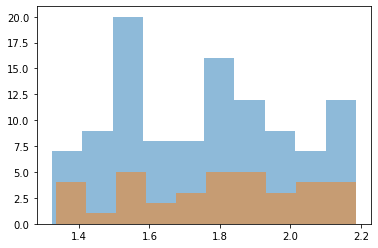

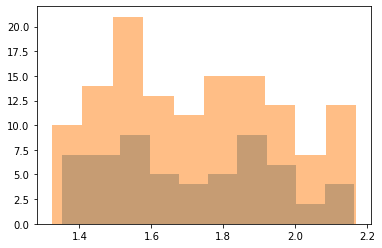

In [37]:
plt.hist(old_ratios4, alpha=0.5)
plt.hist(old_ratios8, alpha=0.5)
plt.show()

plt.hist(young_ratios4, alpha=0.5)
plt.hist(young_ratios8, alpha=0.5)
plt.show()

#### Let's ask this question in a Bayesian way: if I flip a fair coin around the 3:2 and 2:1 period ratios, to what confidence can I claim that the observed period ratios come from a biased coin, and how biased? 

In [38]:
#all_ratios_3_2 = all_ratios[(all_ratios > 1.4) & (all_ratios < 1.6)]
#all_ratios_2_1 = all_ratios[(all_ratios > 1.9) & (all_ratios < 2.1)]
#print(all_ratios_3_2)
#print(all_ratios_2_1)

### 4 Gyrs
# 3:2
young4_3_2 = young_ratios4[(young_ratios4 > 1.4) & (young_ratios4 < 1.6)]
old4_3_2 = old_ratios4[(old_ratios4 > 1.4) & (old_ratios4 < 1.6)]

# 2:1
young4_2_1 = young_ratios6[(young_ratios6 > 1.9) & (young_ratios6 < 2.1)]
old4_2_1 = old_ratios6[(old_ratios6 > 1.9) & (old_ratios6 < 2.1)]

### 6 Gyrs
# 3:2
young6_3_2 = young_ratios6[(young_ratios6 > 1.4) & (young_ratios6 < 1.6)]
old6_3_2 = old_ratios6[(old_ratios6 > 1.4) & (old_ratios6 < 1.6)]

# 2:1
young6_2_1 = young_ratios6[(young_ratios6 > 1.9) & (young_ratios6 < 2.1)]
old6_2_1 = old_ratios6[(old_ratios6 > 1.9) & (old_ratios6 < 2.1)]

### 8 Gyrs
# 3:2
young8_3_2 = young_ratios8[(young_ratios8 > 1.4) & (young_ratios8 < 1.6)]
old8_3_2 = old_ratios8[(old_ratios8 > 1.4) & (old_ratios8 < 1.6)]

# 2:1
young8_2_1 = young_ratios8[(young_ratios8 > 1.9) & (young_ratios8 < 2.1)]
old8_2_1 = old_ratios8[(old_ratios8 > 1.9) & (old_ratios8 < 2.1)]

6 12
9 20
13 8
8 6
11 24
4 8
13 8
8 6
14 26
1 6
16 9
5 5


FileNotFoundError: [Errno 2] No such file or directory: 'paper/period_ratio_young_old_3_2_8gyrs.pdf'

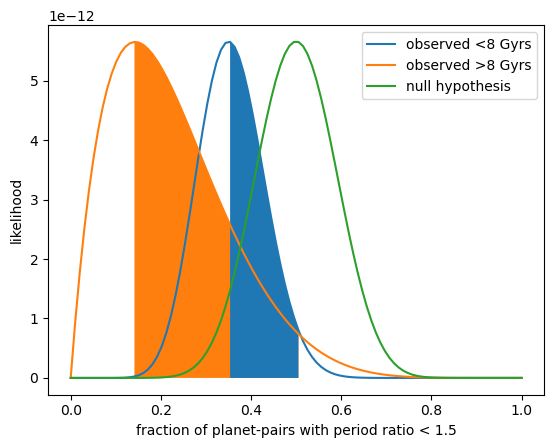

In [39]:
def binomial_pmf(f, array, ratio): 
    
    """
    Compute bionmial distribution probability mass function (PMF). 
    If I toss a coin and get some observed distribution of planet period ratios < and > than some integer ratio, 
    what's the probability that the true bias of the coin is f? 
    That is, if the coin is fair (if planet pairs are evenly distributed around integer ratios), 
    then I'd expect the peak of the likelihood function to be at f=0.5.
    
    Inputs:
    - f: coin bias test fraction
    - array: array of observed ratios [np.array]
    - ratio: the planet-period ratio in question
    
    Returns:
    - PMF: probability mass function
    
    """
    
    less_than = array[(array >= ratio - 0.1) & (array <= ratio)]
    greater_than = array[(array <= ratio + 0.1) & (array >= ratio)]
    print(len(less_than), len(greater_than))
    
    likelihood = f**(len(less_than)) * (1-f)**(len(greater_than))
                   
    return likelihood

def binomial_null(f):
    
    """
    Construct fair-coin-toss binomial distribution.
    Let's say we toss the fair coin 30 times.
    """
    
    likelihood = (f**15) * ((1-f)**15)
    
    return likelihood

import matplotlib
plt.rcParams.update(matplotlib.rcParamsDefault)

### calculate binomial PMFs
ratio = 1.5
threshold = 8
fs = np.linspace(0, 1, 100)
#fair_likelihoods = binomial_pmf(fs, young_ratios, ratio) # all_ratios
binomial_young4_3_2 = binomial_pmf(fs, young4_3_2, 1.5) 
binomial_old4_3_2 = binomial_pmf(fs, old4_3_2, 1.5) 
binomial_young4_2_1 = binomial_pmf(fs, young4_2_1, 2) 
binomial_old4_2_1 = binomial_pmf(fs, old4_2_1, 2) 

binomial_young6_3_2 = binomial_pmf(fs, young6_3_2, 1.5) 
binomial_old6_3_2 = binomial_pmf(fs, old6_3_2, 1.5) 
binomial_young6_2_1 = binomial_pmf(fs, young6_2_1, 2) 
binomial_old6_2_1 = binomial_pmf(fs, old6_2_1, 2) 

binomial_young8_3_2 = binomial_pmf(fs, young8_3_2, 1.5) 
binomial_old8_3_2 = binomial_pmf(fs, old8_3_2, 1.5) 
binomial_young8_2_1 = binomial_pmf(fs, young8_2_1, 2) 
binomial_old8_2_1 = binomial_pmf(fs, old8_2_1, 2) 

### normalize
#fair_likelihoods_old4_normalized = fair_likelihoods_old4*(max(fair_likelihoods_young4)/max(fair_likelihoods_old4))
normalized_binomial_null = binomial_null(fs)*(max(binomial_young8_3_2)/max(binomial_null(fs)))
binomial_old4_3_2_normalized = binomial_old4_3_2*(max(binomial_young4_3_2)/max(binomial_old4_3_2))
binomial_old4_2_1_normalized = binomial_old4_2_1*(max(binomial_young4_2_1)/max(binomial_old4_2_1))
binomial_old6_3_2_normalized = binomial_old6_3_2*(max(binomial_young6_3_2)/max(binomial_old6_3_2))
binomial_old6_2_1_normalized = binomial_old6_2_1*(max(binomial_young6_2_1)/max(binomial_old6_2_1))
binomial_old8_3_2_normalized = binomial_old8_3_2*(max(binomial_young8_3_2)/max(binomial_old8_3_2))
binomial_old8_2_1_normalized = binomial_old8_2_1*(max(binomial_young8_2_1)/max(binomial_old8_2_1))

### plot to compare young vs old
plt.plot(fs, binomial_young8_3_2, label=f'observed <{threshold} Gyrs')
plt.plot(fs, binomial_old8_3_2_normalized, label=f'observed >{threshold} Gyrs')
plt.plot(fs, normalized_binomial_null, label=r'null hypothesis')
plt.fill_between(fs[np.argmax(binomial_young8_3_2):51], binomial_young8_3_2[np.argmax(binomial_young8_3_2):51], zorder=2)
plt.fill_between(fs[np.argmax(binomial_old8_3_2_normalized):51], binomial_old8_3_2_normalized[np.argmax(binomial_old8_3_2_normalized):51], zorder=1)

plt.xlabel(f'fraction of planet-pairs with period ratio < {ratio}')
plt.ylabel('likelihood')
#plt.legend(bbox_to_anchor=(1.05, 1))
plt.legend()
plt.savefig('paper/period_ratio_young_old_3_2_8gyrs.pdf', format='pdf', facecolor='white',
           bbox_inches='tight')
plt.show()

"""
### plot to compare different "older than"s
plt.plot(fs, fair_likelihoods_old4, label=f'observed >4 Gyrs')
plt.plot(fs, fair_likelihoods_old6_normalized, label=f'observed >6 Gyrs')
#plt.plot(fs, normalized_binomial_null, label=r'null hypothesis')
plt.fill_between(fs[np.argmax(fair_likelihoods_old4):51], fair_likelihoods_old4[np.argmax(fair_likelihoods_old4):51])
plt.fill_between(fs[50:np.argmax(fair_likelihoods_old6_normalized)+1], fair_likelihoods_old6_normalized[50:np.argmax(fair_likelihoods_old6_normalized)+1])

plt.xlabel(f'fraction of planet-pairs with period ratio < {ratio}')
plt.ylabel('likelihood')
plt.legend()
#plt.savefig('paper/period_ratio_old_4_6gyrs.pdf', format='pdf')
#plt.savefig('paper/period_ratio_3_2_bayes.pdf', format='pdf')
plt.show()
"""


In [659]:
print("total area under PMF: ", np.trapz(normalized_binomial_null))
print("1 sigma: ", 0.34*np.trapz(normalized_binomial_null))
#area_deviation = np.trapz(binomial_young4_2_1[np.argmax(binomial_young4_2_1):51])
area_deviation = np.trapz(binomial_young4_2_1[50:np.argmax(binomial_young4_2_1)+1])
print("area from peak of PMF to f = 0.5: ", area_deviation)
print("area from peak of PMF to f = 0.5 in sigmas: ", area_deviation/(0.34*np.trapz(normalized_binomial_null)))


total area under PMF:  0.0005599398109936407
1 sigma:  0.00019037953573783784
area from peak of PMF to f = 0.5:  0.0002622822330596965
area from peak of PMF to f = 0.5 in sigmas:  1.3776808102992344


In [635]:
from scipy import signal
null_width = scipy.signal.peak_widths(normalized_binomial_null, [np.argmax(normalized_binomial_null)])
print(null_width)
print(null_width[0][0]/100)
print("distance between peaks: ", 
      (np.argmax(normalized_binomial_null)-np.argmax(binomial_young8_3_2))/(null_width[0][0]))


(array([21.061802]), array([5.4454938e-05]), array([38.969099]), array([60.030901]))
0.21061801996516039
distance between peaks:  0.5697518190506679


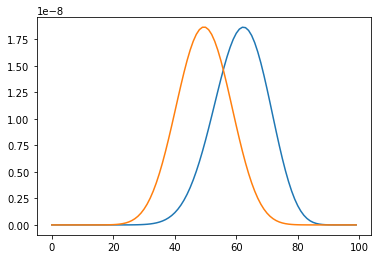

In [439]:
plt.plot(fair_likelihoods)
plt.plot(normalized_binomial_null)
plt.show()

#### Wait, why were there 900 planets before joining with NASA Exoplanets Archive? 

In [ ]:
ds1 = set(kepler_stellar_enriched.kepid)
ds2 = set(crossmatch.loc[crossmatch['planet?'] != 'none'].kepid)
print(len(ds1))
print(len(ds2))
print(ds2.difference(ds1))

Plugged a few of these into MAST and they were all false positives. Then did the same for the kepler_stellar_enriched kepids and they were all planets. Looks like the Bedell cross-match was just out of date?

#### Tests on thresholding vs flag with Sarah B on 17 Aug 2022 

In [254]:
no_score = kois.loc[kois.koi_score.isna()]
#pd.merge(kepler_stellar, positives_kepler, how='inner', left_on='kepid', right_on='kepid')

In [256]:
kepler_planet_enriched_no_score = pd.merge(kepler_stellar, no_score, how='inner', left_on='kepid', right_on='kepid')
print(len(kepler_planet_enriched_no_score.kepid.unique()))

595


In [251]:
len(kepler_planet_enriched.loc[kepler_planet_enriched.koi_score.isna()].kepid.unique())

193

In [244]:
len(positives_kepler_cfp.loc[positives_kepler_cfp.koi_disposition=='FALSE POSITIVE'].kepid.unique())

7

(array([138., 189., 186., 131., 110.,  80.,  37.,  16.,   8.,   8.]),
 array([ 0.81 ,  2.437,  4.064,  5.691,  7.318,  8.945, 10.572, 12.199,
        13.826, 15.453, 17.08 ]),
 <BarContainer object of 10 artists>)

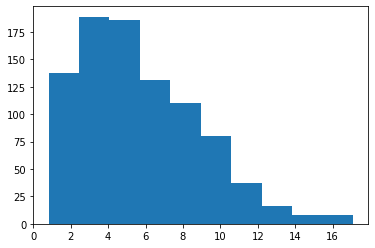

In [258]:
plt.hist(kepler_planet_enriched_cfp.iso_age) # age distribution of the 811 systems that match Berger and have koi_score>0.5

In [ ]:
kepler_planet_enriched_cfp = pd.merge(kepler_stellar, positives_kepler_cfp, how='inner', left_on='kepid', right_on='kepid')
print(len(kepler_planet_enriched_cfp))
print(len(kepler_planet_enriched_cfp.kepid.unique()))

print(kepler_planet_enriched_cfp.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())

In [238]:
len(kois.loc[kois.koi_score.isna()].kepid.unique())
sad = kois.loc[kois.koi_score.isna()]
print(len(sad.loc[sad.koi_disposition!='FALSE POSITIVE'].kepid.unique()))
#len(kois.loc[kois.koi_score.isna()].kepid.unique())

595


### Age threshold effect on young-old multiplicities

Which threshold yields the greatest difference between the observed young and old transit multiplicities?

In [24]:
k = kepler_planet_enriched.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid + np.array([4, 4, 4, 4, 4])
k = list(k)
k += [0.] * (7 - len(k)) # pad
k = np.array(k)

In [26]:
kepler_planet_enriched.iso_age_err = 0.5 * (np.abs(kepler_planet_enriched.iso_age_err1) + np.abs(kepler_planet_enriched.iso_age_err2))


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_23568/2077406791.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  kepler_planet_enriched.iso_age_err = 0.5 * (np.abs(kepler_planet_enriched.iso_age_err1) + np.abs(kepler_planet_enriched.iso_age_err2))


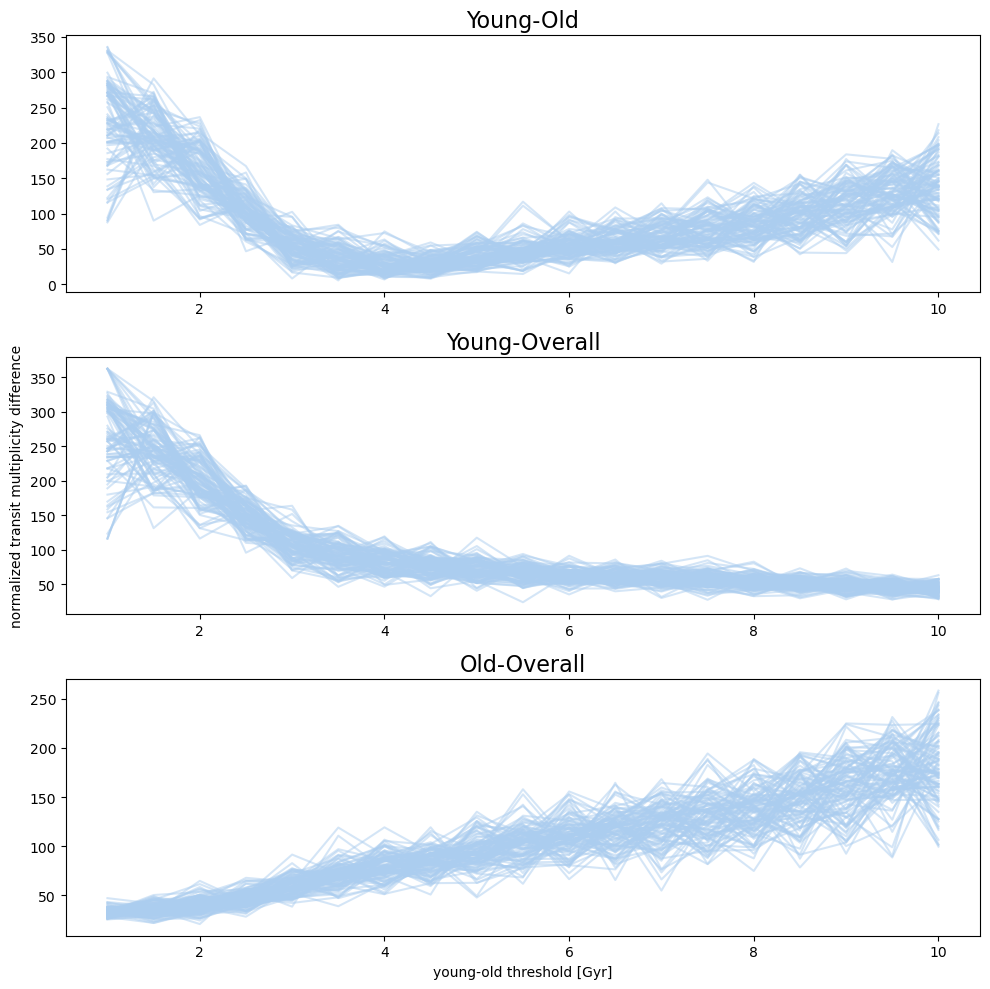

In [772]:
bootstrap = 100
thresholds = np.linspace(1, 10, 19)

fig, axes = plt.subplots(figsize=(10,10))

for b in range(bootstrap):
    young_multiplicities = []
    old_multiplicities = []
    young_differences = []
    old_differences = []
    residuals = []

    ### for each threshold, compute young-old multiplicities and their difference
    for threshold in thresholds:
        #for i in bootstrap:
        kepler_planet_enriched.iso_age_sample = np.random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)

        # young
        young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample <= threshold] # iso_age_sample
        young_multiplicity = list(young.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        young_multiplicity += [0.] * (7 - len(young_multiplicity)) # pad
        young_multiplicity = np.array(young_multiplicity) * np.sum(k) / np.sum(young_multiplicity) # normalize
        young_multiplicities.append(young_multiplicity)

        young_difference = np.abs(young_multiplicity - k) # how much does multiplicity differ from overall sample?
        young_differences.append(young_difference)

        # old
        old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample > threshold]
        old_multiplicity = list(old.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        old_multiplicity += [0.] * (7 - len(old_multiplicity))
        old_multiplicity = np.array(old_multiplicity) * np.sum(k) / np.sum(old_multiplicity)
        old_multiplicities.append(old_multiplicity)

        old_difference = np.abs(old_multiplicity - k)
        old_differences.append(old_difference)

        # residuals
        residual = np.array(young_multiplicity) - np.array(old_multiplicity)
        residual = np.abs(residual)
        residuals.append(residual)


    ### which threshold has greatest young-old difference in observed transit multiplicity?
    residuals = [np.sum(i) for i in residuals]
    #print(np.argmax(residuals))
    #print("Old vs Young: ", residuals)

    ### which threshold has greatest young-overall or old-overall difference in transit multiplicity?
    old_differences = [np.sum(i) for i in old_differences]
    young_differences = [np.sum(i) for i in young_differences]
    #print(np.argmax(old_differences))
    #print("Old vs Overall: ", old_differences)

    #print(np.argmax(young_differences))
    #print("Young vs Overall: ", young_differences)
    
    ax1 = plt.subplot(311)
    ax1.plot(thresholds, residuals, color='#abcdef', alpha=0.5)

    ax2 = plt.subplot(312)
    ax2.plot(thresholds, young_differences, color='#abcdef', alpha=0.5)
    
    ax3 = plt.subplot(313)
    ax3.plot(thresholds, old_differences, color='#abcdef', alpha=0.5)
    
ax1.set_title('Young-Old', size=16)
ax2.set_title('Young-Overall', size=16)
ax2.set_ylabel('normalized transit multiplicity difference')
ax3.set_title('Old-Overall', size=16)
ax3.set_xlabel('young-old threshold [Gyr]')

plt.tight_layout()
plt.savefig('paper/young-old-overall-differences.png', format='png')
plt.show()

/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_23568/1434665903.py:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(311)


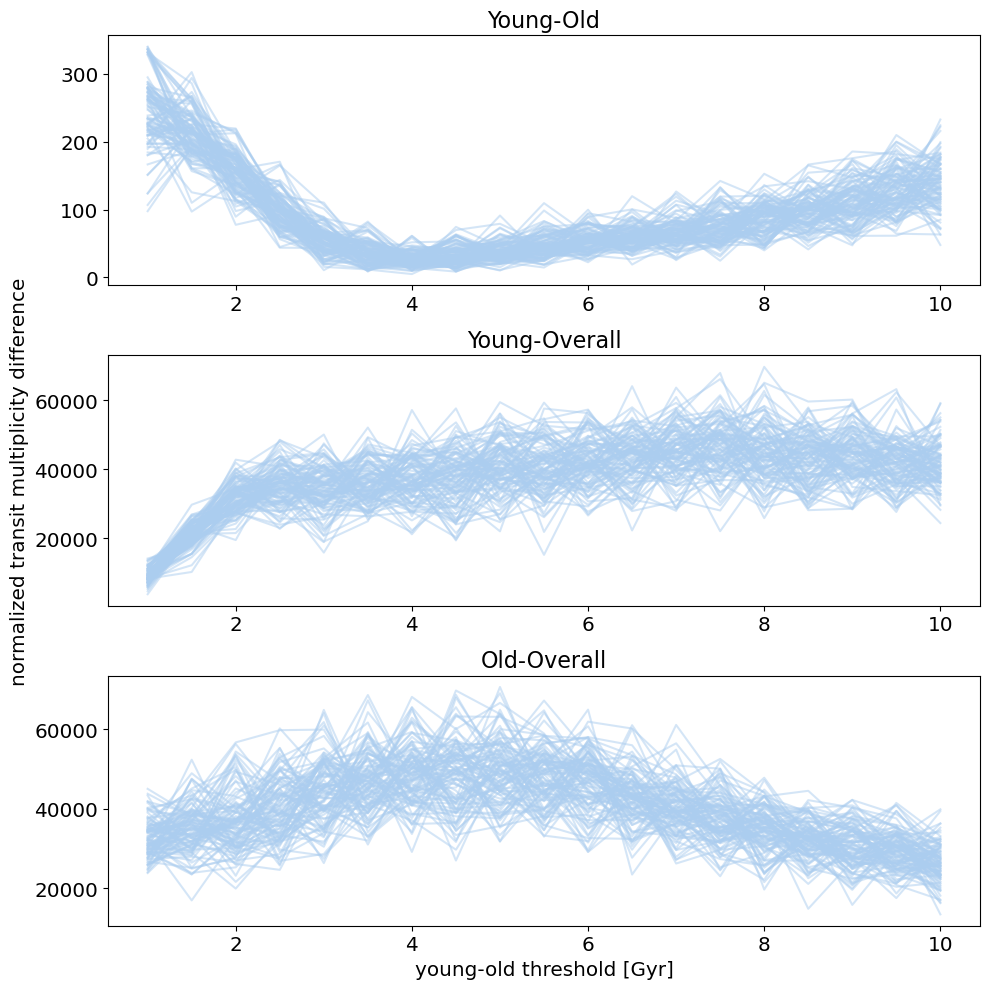

In [28]:
bootstrap = 100
thresholds = np.linspace(1, 10, 19)

fig, axes = plt.subplots(figsize=(10,10))

for b in range(bootstrap):
    young_multiplicities = []
    old_multiplicities = []
    young_differences = []
    old_differences = []
    residuals = []

    ### for each threshold, compute young-old multiplicities and their difference
    for threshold in thresholds:
        #for i in bootstrap:
        kepler_planet_enriched.iso_age_sample = np.random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)

        # young
        young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample <= threshold] # iso_age_sample
        young_multiplicity = list(young.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        young_multiplicity += [0.] * (7 - len(young_multiplicity)) # pad
        young_multiplicity = np.array(young_multiplicity) * np.sum(k) / np.sum(young_multiplicity) # normalize
        young_multiplicities.append(young_multiplicity)

        young_difference = np.abs(young_multiplicity - k) # how much does multiplicity differ from overall sample?
        young_difference = young_difference * len(young) # normalize by size of bin 
        young_differences.append(young_difference)

        # old
        old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample > threshold]
        old_multiplicity = list(old.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        old_multiplicity += [0.] * (7 - len(old_multiplicity))
        old_multiplicity = np.array(old_multiplicity) * np.sum(k) / np.sum(old_multiplicity)
        old_multiplicities.append(old_multiplicity)

        old_difference = np.abs(old_multiplicity - k)
        old_difference = old_difference * len(old) # normalize by size of bin
        old_differences.append(old_difference)

        # residuals
        residual = np.array(young_multiplicity) - np.array(old_multiplicity)
        residual = np.abs(residual)
        residuals.append(residual)


    ### which threshold has greatest young-old difference in observed transit multiplicity?
    residuals = [np.sum(i) for i in residuals]
    #print(np.argmax(residuals))
    #print("Old vs Young: ", residuals)

    ### which threshold has greatest young-overall or old-overall difference in transit multiplicity?
    old_differences = [np.sum(i) for i in old_differences]
    young_differences = [np.sum(i) for i in young_differences]
    #print(np.argmax(old_differences))
    #print("Old vs Overall: ", old_differences)

    #print(np.argmax(young_differences))
    #print("Young vs Overall: ", young_differences)
    
    ax1 = plt.subplot(311)
    ax1.plot(thresholds, residuals, color='#abcdef', alpha=0.5)

    ax2 = plt.subplot(312)
    ax2.plot(thresholds, young_differences, color='#abcdef', alpha=0.5)
    
    ax3 = plt.subplot(313)
    ax3.plot(thresholds, old_differences, color='#abcdef', alpha=0.5)
    
ax1.set_title('Young-Old', size=16)
ax2.set_title('Young-Overall', size=16)
ax2.set_ylabel('normalized transit multiplicity difference')
ax3.set_title('Old-Overall', size=16)
ax3.set_xlabel('young-old threshold [Gyr]')

plt.tight_layout()
#plt.savefig('paper/young-old-overall-differences.png', format='png')
plt.show()

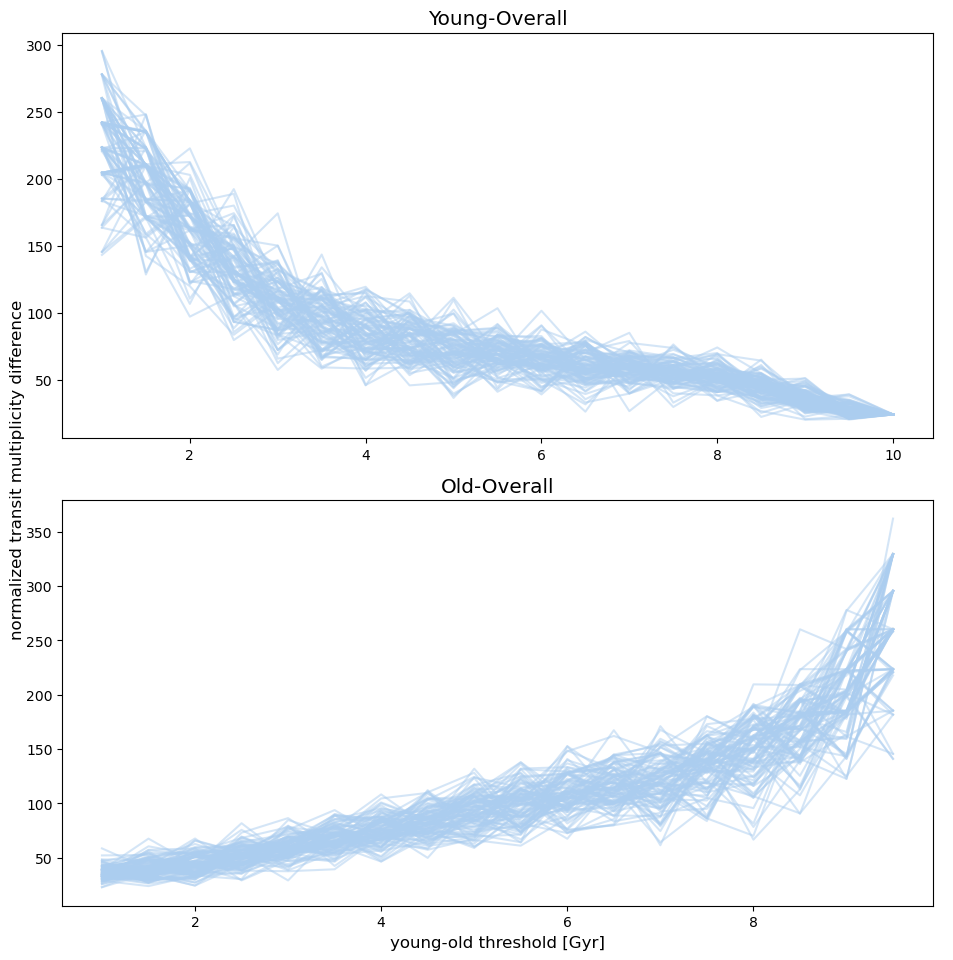

In [71]:
import warnings
warnings.filterwarnings("ignore")

bootstrap = 100
thresholds = np.linspace(1, 10, 19)
thresholds_quantiled = np.linspace(0.1, 1, 19)

fig, axes = plt.subplots(figsize=(10,10), sharex = True, sharey=True)

for b in range(bootstrap):
    young_multiplicities = []
    old_multiplicities = []
    young_differences = []
    old_differences = []
    residuals = []

    ### for each threshold, compute young-old multiplicities and their difference
    for threshold in thresholds_quantiled:
        #for i in bootstrap:
        kepler_planet_enriched.iso_age_sample = np.random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)

        # young
        young = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample <= pd.DataFrame(kepler_planet_enriched.iso_age_sample).quantile(threshold)[0]] # iso_age_sample compared to quantiled age thresholds for uniformly sized bins
        young_multiplicity = list(young.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        young_multiplicity += [0.] * (7 - len(young_multiplicity)) # pad
        young_multiplicity = np.array(young_multiplicity) * np.sum(k) / np.sum(young_multiplicity) # normalize
        young_multiplicities.append(young_multiplicity)

        young_difference = np.abs(young_multiplicity - k) # how much does multiplicity differ from overall sample?
        young_differences.append(young_difference)

        # old
        old = kepler_planet_enriched.loc[kepler_planet_enriched.iso_age_sample > pd.DataFrame(kepler_planet_enriched.iso_age_sample).quantile(threshold)[0]] # kepler_planet_enriched.iso_age_sample.quantile(threshold)
        old_multiplicity = list(old.groupby(['kepid']).count()['koi_count'].reset_index().groupby('koi_count').count().reset_index().kepid)
        old_multiplicity += [0.] * (7 - len(old_multiplicity))
        old_multiplicity = np.array(old_multiplicity) * np.sum(k) / np.sum(old_multiplicity)
        old_multiplicities.append(old_multiplicity)

        old_difference = np.abs(old_multiplicity - k)
        old_differences.append(old_difference)

        # residuals
        residual = np.array(young_multiplicity) - np.array(old_multiplicity)
        residual = np.abs(residual)
        residuals.append(residual)


    ### which threshold has greatest young-old difference in observed transit multiplicity?
    residuals = [np.sum(i) for i in residuals]
    #print(np.argmax(residuals))
    #print("Old vs Young: ", residuals)

    ### which threshold has greatest young-overall or old-overall difference in transit multiplicity?
    old_differences = [np.sum(i) for i in old_differences]
    young_differences = [np.sum(i) for i in young_differences]
    #print(np.argmax(old_differences))
    #print("Old vs Overall: ", old_differences)

    #print(np.argmax(young_differences))
    #print("Young vs Overall: ", young_differences)
    
    ax2 = plt.subplot(211)
    ax2.plot(thresholds, young_differences, color='#abcdef', alpha=0.5)
    
    ax3 = plt.subplot(212)
    ax3.plot(thresholds, old_differences, color='#abcdef', alpha=0.5)
    
ax2.set_title('Young-Overall')
ax3.set_title('Old-Overall')
#ax3.set_xlabel('young-old threshold [Gyr]')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('normalized transit multiplicity difference')
plt.xlabel('young-old threshold [Gyr]')
plt.tight_layout()
plt.savefig('paper/young-old-differences.png', format='png')
plt.show()

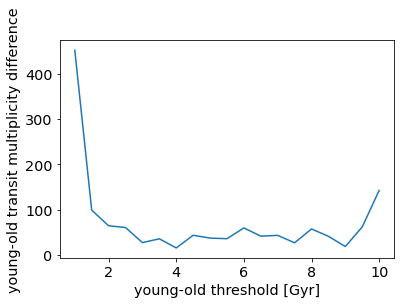

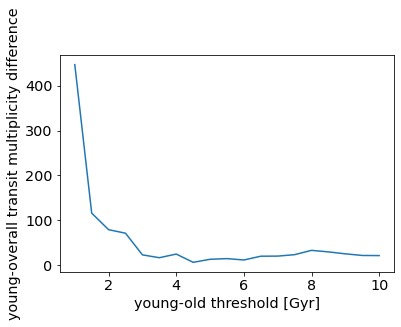

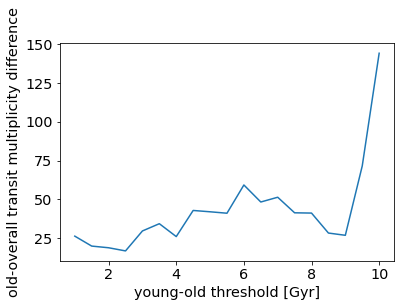

In [730]:
plt.plot(thresholds, residuals)
plt.ylabel('young-old transit multiplicity difference')
plt.xlabel('young-old threshold [Gyr]')
plt.show()

plt.plot(thresholds, young_differences)
plt.ylabel('young-overall transit multiplicity difference')
plt.xlabel('young-old threshold [Gyr]')
plt.show()

plt.plot(thresholds, old_differences)
plt.ylabel('old-overall transit multiplicity difference')
plt.xlabel('young-old threshold [Gyr]')
plt.show()

Outside of the most extremes of 1 and 10 Gyrs, there doesn't seem to be any specific threshold that creates a noticeably big mismatch in young-old transit multiplicities.